In our DRAF we pose the problem:

$$ \min_{\beta} ||\bar{B}\beta -x ||_{2}^2$$
$$\text{s.t} \beta_i^{||.||} \leq \gamma w_{l_i}$$

To apply R-RF we need a lasso problem (that is, the restriction should be $ || \beta_i^{||.||} ||_1 \leq c$), for the moment, we will pose a relaxation of the problem:

$$ \min_{\beta} ||\bar{B}\beta -x ||_{2}^2$$
$$\text{s.t} \sum_{i} \beta_i^{||.||} \leq \gamma \sum_{i}w_{l_i}$$

note that $\sum_{i} \beta_i^{||.||} = ||\beta^{||.||}||_1$, as all the components of $\beta_i^{||.||}$ are positive. Sin embargo tenemos un problema en el planteamiento del problema de minimos cuadrados, especilamente en la restricción.

En el DRAFT definimos:

$$\beta^{||.||} = \begin{bmatrix}
           ||\lambda_1||_{2} \\
           ||\lambda_2||_{2} \\
           \vdots \\
           ||\lambda_3||_{2}
         \end{bmatrix}$$

Sin embargo para poder trabjar con lasso debemos tener restricciones en terminos de la norma $1$, es decir debemos trabajar con el vector:

$$\beta^{||.||}_1 = \begin{bmatrix}
           ||\lambda_1||_{1} \\
           ||\lambda_2||_{1} \\
           \vdots \\
           ||\lambda_3||_{1}
        \end{bmatrix}$$

Note que $\frac{1}{p}||\lambda_i||_{1} < ||\lambda_i||_{2}  \leq \gamma w_{l_i}$ y de esta forma: $\frac{1}{p} \sum_{i}||\lambda_i||_{1} = \frac{1}{p} ||\beta||_1 = ||\beta||_< \gamma \sum_{i}w_{l_i}$. Entonces neustro problema reformulado es:


$$ \min_{\beta} ||\bar{B}\beta -x ||_{2}^2$$
$$\text{s.t} \sum_{i} \beta_{1,i}^{||.||} = ||\beta^{||.||}_1||_1 = ||\beta||_1 \leq p\gamma \sum_{i}w_{l_i}$$

Pasaremos entonces a implementar R-FS en nuestro problema jugete:

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [106]:
X_or = np.array([
    [1,1],
    [1,2],
    [2,1],
    [2,2]
])

X_ref = -X_or

X = np.vstack((X_or, X_ref))

Pesos:

In [107]:
def knn_w(X, k=3, phi=0.5):

    D = cdist(X,X, 'euclidean')
    np.fill_diagonal(D, np.inf)

    n = D.shape[0]
    W = np.zeros((n,n))

    for i in range(n): #Recorremos cada punto
        idx = np.argsort(D[i,:]) #Indices de los k vecinos más cercanos
        for j in idx[0:k]:  # skip the first one since it's the point itself
            W[i,j] = np.exp(-phi * D[i,j])

    W = np.maximum(W, W.T)  # Hacer la matriz simétrica
    
    return W

In [108]:
W_knn = knn_w(X, k=3, phi=0.25)

In [109]:
def plot_graph_weights(X, W, title):
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X[:,0], X[:,1], c='steelblue', s=80, zorder=3)
    
    nonzero_W = W[W > 0]
    vmin, vmax = np.min(nonzero_W), np.max(nonzero_W)
    
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if W[i,j] > 0:
                plt.plot(
                    [X[i,0], X[j,0]],
                    [X[i,1], X[j,1]],
                    color=plt.cm.plasma((W[i,j]-vmin)/(vmax-vmin)),
                    linewidth=2.5 * (W[i,j]/vmax),
                    alpha=0.9
                )
    
    # Etiquetas de nodos
    for i, (x, y) in enumerate(X):
        plt.text(x+0.05, y+0.05, f"{i}", fontsize=11, color="black")

    sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax = ax)
    cbar.set_label('Edge Weights', rotation=270, labelpad=15)

    ax.set_title(title)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()


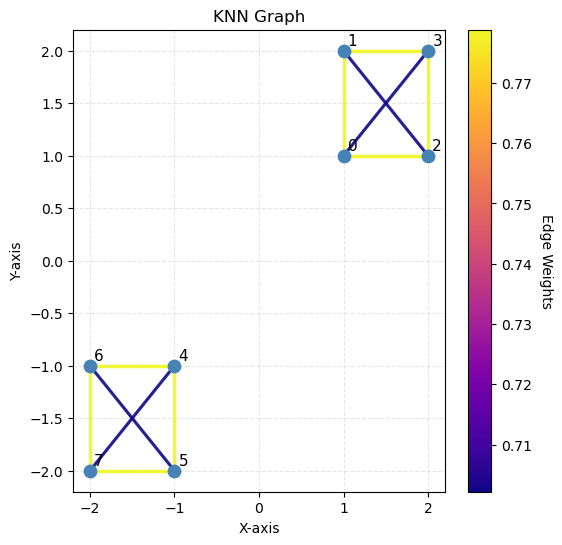

In [110]:
plot_graph_weights(X, W_knn, "KNN Graph")

Ahora para llegar a nuestro problema debemos tener: La matriz $\bar{B}$, la constante $p\gamma \sum_{i}w_{l_i}$ y el vector de los datos $x$



$$\bold{p \gamma \sum_i w_{l_i}}$$

In [111]:
def lassoconstant(W,gamma =1, p=2):
    """
    Lasso constant for the relaxation problem.
    Parameters:
    ----------
    W : np.ndarray
        Weight matrix. 
    gamma : float
        Regularization parameter.
    p : int
        Dimensionality of the data.
    Returns:
    -------
    float
        Lasso constant.
    """
    return p * gamma * np.sum(W)

$$\bar{B}$$

In [112]:
import networkx as nx

def built_edges(W):
    """
    Build edges and weights from the weight matrix W.
    Parameters:
        W: Weight matrix.
    Returns:  
        edges: List of edges.
    """
    n = W.shape[0] 
    edges = []
    for i in range(n):
        for j in range(i+1, n):
            if W[i,j] > 0:
                edges.append((i,j))

    return edges

def BigB(W, n):
    """
    Build incidence matrix from edges.
    Parameters:
        W: Weight matrix.
        n: Dimention of the data.
    Returns:
        B: Incidence matrix.
    """
    edges = built_edges(W)
    G = nx.Graph()
    G.add_edges_from(edges)
    B = -nx.incidence_matrix(G, oriented=True, dtype= float).toarray()
    barB = np.kron(B, np.eye(n))
    return barB, edges

In [113]:
barB = BigB(W_knn, 2)[0]

$$\bold{x}$$

In [114]:
def vop(X):
    return X.flatten()

In [ ]:
import cvxpy as cp

def beta_lasso(W, X, dim, gamma):
    """"
    Solve the lasso problem to find beta.
    Parameters:
        W_knn: Weight matrix.
        X: Data matrix.
        dim: Dimention of the data.
        gamma: Regularization parameter.
    Returns:
        beta: Solution of the lasso problem.
        value: Optimal value of the objective function.
    """   
    
    edges = built_edges(W)
    
    barB = BigB(W, dim)[0]

    beta = cp.Variable(len(edges)*dim)

    constraints = [cp.norm1(beta) <= lassoconstant(W, gamma=gamma, p=dim)]

    objective = cp.Minimize(cp.norm2(barB @ beta - vop(X))**2)
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return beta.value, prob.value


## Lasso 4 points

We know use the formulation of our problem, first we do lasso with ```scikit-learn```

### 4 points, knn weigths

In [79]:
beta, val = beta_lasso(W_knn, X, dim=2, gamma=0.5)

Optimos, usando las ecuaciones $(8)$ y $(4)$

In [80]:
deltas = barB @ beta

In [81]:
centersvect =vop(X) - deltas

Imprimimos los centros

In [82]:
centers = []
for i in range(0,len(centersvect),2):
    centers.append(tuple(centersvect[i:i+2]))

Ahora imprimimos los resultados

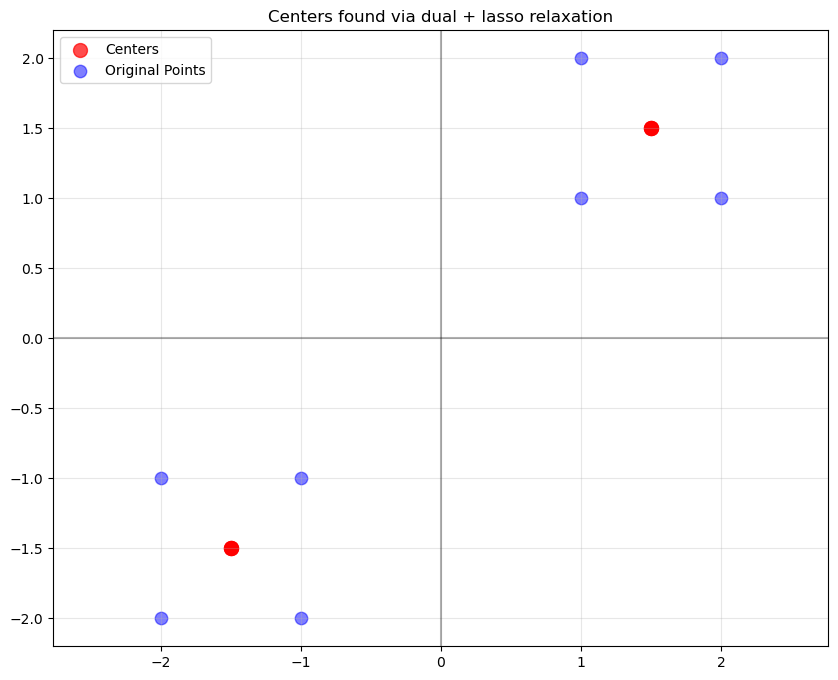

In [84]:
x = [p[0] for p in centers]
y = [p[1] for p in centers]
x_points = [p[0] for p in X]
y_points = [p[1] for p in X]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='red', s=100, alpha=0.7, label='Centers')
plt.scatter(x_points, y_points, color='blue', s=80, alpha=0.5, label='Original Points')
plt.title('Centers found via dual + lasso relaxation')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.legend()
plt.axis('equal') 
plt.show()

### 4 points, fully conected

In [85]:
def fully_connected_w(X):

    D = cdist(X,X, 'euclidean')
    D = np.maximum(D, 1e-10)
    W = 1 / np.square(D)
    W = np.minimum(W, 1e10)
    np.fill_diagonal(W, 0)
    
    return W

In [104]:
W = fully_connected_w(X)
barB_full = BigB(W, 2)[0]
beta_fully, val_fully = beta_lasso(W, X, dim=2, gamma=0.125)

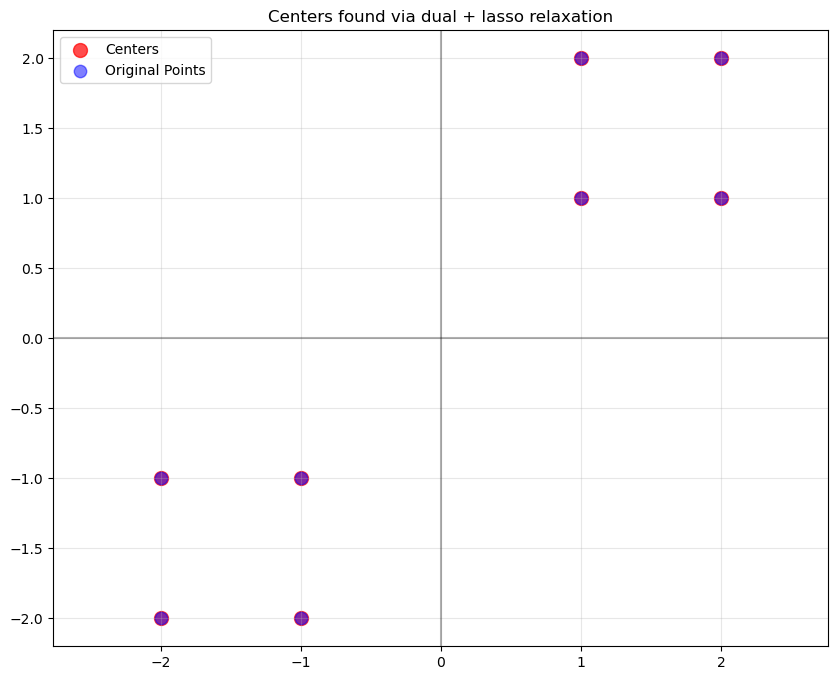

In [103]:
deltas = barB_full @ beta_fully
centersvect =vop(X) - deltas

centers = []
for i in range(0,len(centersvect),2):
    centers.append(tuple(centersvect[i:i+2]))

x = [p[0] for p in centers]
y = [p[1] for p in centers]
x_points = [p[0] for p in X]
y_points = [p[1] for p in X]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='red', s=100, alpha=0.7, label='Centers')
plt.scatter(x_points, y_points, color='blue', s=80, alpha=0.5, label='Original Points')
plt.title('Centers found via dual + lasso relaxation')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.legend()
plt.axis('equal') 
plt.show()

Conluimos que el algoritmo funciona. Ahora aplicamos nuestro trabajo con Boosting

__Boosting__

In [18]:
barB.shape

(16, 24)

In [19]:
vop(X).shape

(16,)

In [21]:
from boosting import Boosting 

exp = Boosting(barB, vop(X))

b = exp.R_FS(delta = 10)

### 4 points, 4-knn weihts

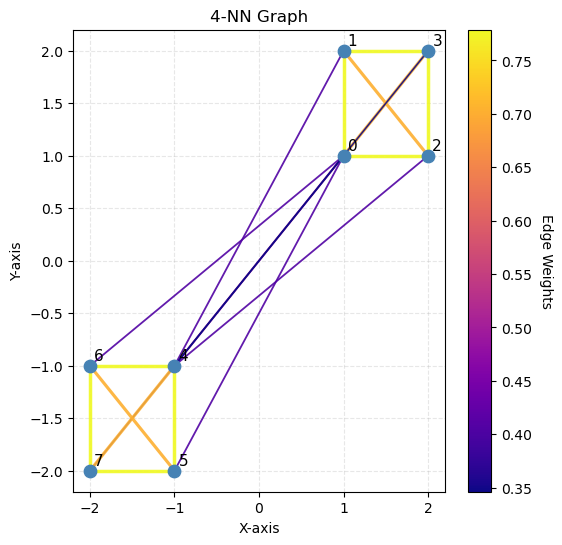

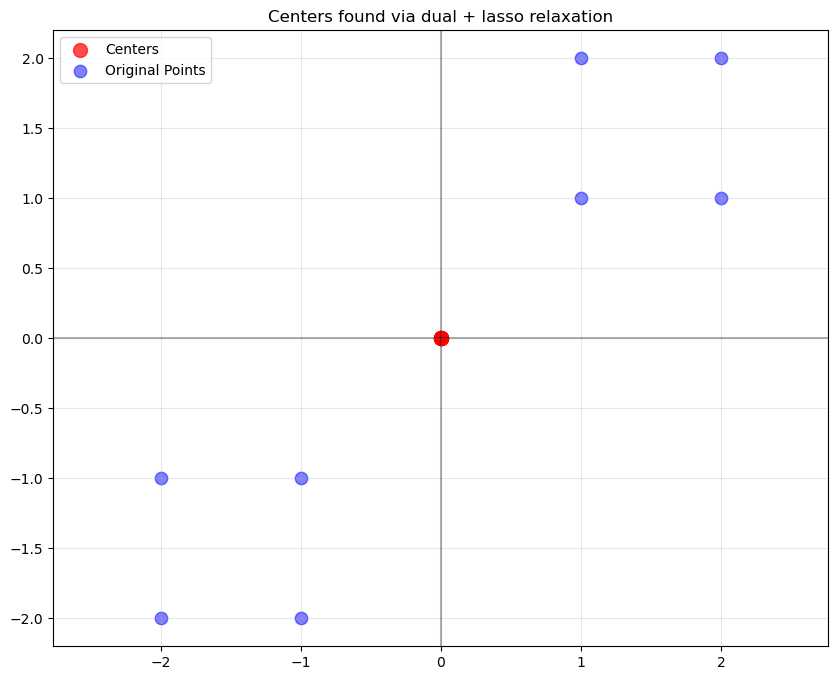

In [119]:
W_knn_4 = knn_w(X, k=4, phi=0.25)

plot_graph_weights(X, W_knn_4, "4-NN Graph")

beta, val = beta_lasso(W_knn_4, X, dim=2, gamma=0.5)

barB_4 = BigB(W_knn_4, 2)[0]
deltas = barB_4 @ beta

centersvect =vop(X) - deltas

centers = []
for i in range(0,len(centersvect),2):
    centers.append(tuple(centersvect[i:i+2]))

x = [p[0] for p in centers]
y = [p[1] for p in centers]
x_points = [p[0] for p in X]
y_points = [p[1] for p in X]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='red', s=100, alpha=0.7, label='Centers')
plt.scatter(x_points, y_points, color='blue', s=80, alpha=0.5, label='Original Points')
plt.title('Centers found via dual + lasso relaxation')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.legend()
plt.axis('equal') 
plt.show()